In [1]:
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda



env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
Loading ARTS API from: /home/dudavid/arts/build//src/arts_api.so


In [2]:
ws = Workspace()
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")


In [3]:
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
ws.ReadXML( ws.abs_lines, "instruments/metmm/abs_lines_metmm.xml.gz")
ws.abs_lines_per_speciesCreateFromLines()

# General Settings

In [4]:
ws.stokes_dim = 1
ws.iy_unit = "PlanckBT"
ws.cloudboxOff()

# Atmosphere 

$$
x = \sum x_i \\
$$


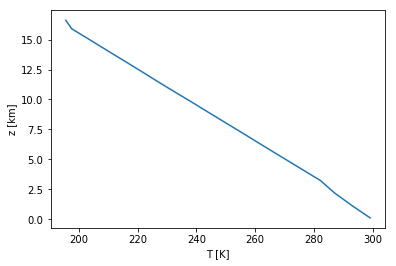

In [5]:
ws.atmosphere_dim = 1
ws.VectorNLogSpace( ws.p_grid, 20, 1e5, 1e4 )
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical")
ws.AtmFieldsCalc()
ws.AbsInputFromAtmFields()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]


plt.plot(np.asarray(ws.t_field).ravel(), np.asarray(ws.z_field).ravel() * 1e-3)
plt.xlabel("T [K]")
plt.ylabel("z [km]")

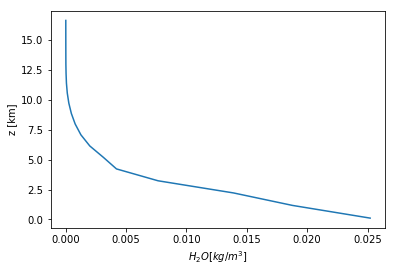

In [6]:
plt.plot(np.asarray(ws.vmr_field)[0,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3)
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")

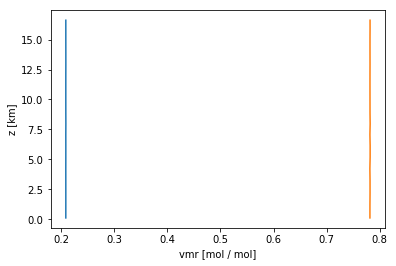

In [7]:
plt.plot(np.asarray(ws.vmr_field)[1,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3, label="$O_2$")
plt.plot(np.asarray(ws.vmr_field)[2,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3, label="$N_2$")
plt.xlabel("vmr [mol / mol]")
plt.ylabel("z [km]")

# Sensor

In [8]:
ws.ArrayOfIndexCreate("channels")
ws.channels = [17,18,19,20,21]
ws.ArrayOfIndexCreate("viewing_angles")
ws.viewing_angles = [47]

ws.sensor_pos  = np.array([[850e3]])
ws.sensor_time = np.array([0.0])
ws.sensor_los  = np.array([[180.0]])

ws.IndexCreate("met_mm_accuracy")
ws.met_mm_accuracy = 1

ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
ws.execute_controlfile("instruments/metmm/common_metmm.arts")

In [9]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.abs_lookupSetup()
ws.abs_lookupCalc()


# Surface 


In [10]:
ws.surface_scalar_reflectivity = np.array([0.5])
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()
ws.jacobianOff()

# Call forward model

In [11]:
ws.yCalc()
ws.y.value

array([ 277.07307601,  270.72121556,  264.62464578,  257.43588112,
        251.26213303])

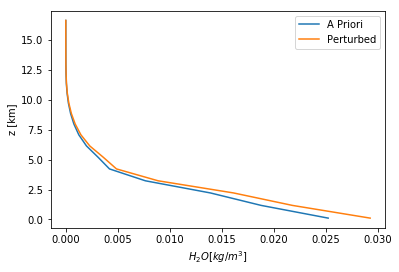

In [12]:
# now change the initial VMR field for water vapor
if not "apriori_h2o" in globals().keys():
    apriori_h2o = np.array(ws.vmr_field)[0,:,0,0]
np.asarray(ws.vmr_field)[0,:,0,0] = apriori_h2o * 1.16
perturbed = np.copy(ws.vmr_field)[0,:,0,0]

plt.plot(apriori_h2o.ravel(), np.asarray(ws.z_field).ravel() * 1e-3, label="A Priori")
plt.plot(ws.vmr_field.value[0,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3, label="Perturbed")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()


# Set up OEM retrieval

In [13]:
ws.retrievalDefInit()
#ws.VectorCreate( ret_vars ) 
nelem = ws.p_grid.value.size
rvars = np.ones(nelem)*1e1   # define apriori variances of retrieved variables
ws.covmatSetDiagonal(rvars)
ws.retrievalAddAbsSpecies(
 species="H2O-PWR98",
 unit="logrel",
 g1=ws.p_grid,
 g2=ws.lat_grid,
 g3=ws.lon_grid
)
se_cov = np.zeros(ws.y.value.size) + 0.5**2 # set channel assumed errors
ws.covmatSetDiagonal(se_cov)
ws.covmat_seSet()
ws.retrievalDefClose()


@arts_agenda
def inversion_iterate_agenda(ws):
    ws.x2artsStandard()  # map x to ARTS's variables
    ws.atmfields_checkedCalc()  # to be safe, rerun checks dealing with atmosph.
    ws.atmgeom_checkedCalc()
    ws.yCalc()  # calculate yf and jacobian matching x
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term
    ws.jacobianAdjustAfterIteration() 
    
ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)
    # last line takes care of some fixes needed to get the jacobian right for iterative solutions
    
#ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)
ws.xaStandard()
ws.Copy(ws.x, ws.xa)
x = np.array([])
yf= np.array([])
ws.jacobian = np.array([[]])

In [14]:

ws.OEM(method="lm",
    max_iter=1000,
    display_progress=1,
    max_start_cost=1e3,
    lm_ga_settings=np.array([10.0,2.0,2.0,100.0,1.0,99.0])
       )


In [15]:
ws.x2artsStandard()


In [16]:
perturbed

array([  2.92547533e-02,   2.17831088e-02,   1.61270156e-02,
         8.86978471e-03,   4.87363549e-03,   3.60915743e-03,
         2.31001653e-03,   1.45490775e-03,   9.02213433e-04,
         5.37961022e-04,   2.94184043e-04,   1.45866937e-04,
         6.55273939e-05,   2.96289693e-05,   1.24967538e-05,
         8.33046432e-06,   5.96917635e-06,   4.40766555e-06,
         3.59492373e-06,   3.41078389e-06])

In [17]:
apriori_h2o

array([  2.52196149e-02,   1.87785420e-02,   1.39025997e-02,
         7.64636613e-03,   4.20140990e-03,   3.11134261e-03,
         1.99139356e-03,   1.25423082e-03,   7.77770201e-04,
         4.63759502e-04,   2.53606934e-04,   1.25747359e-04,
         5.64891326e-05,   2.55422149e-05,   1.07730636e-05,
         7.18143476e-06,   5.14584168e-06,   3.79971168e-06,
         3.09907218e-06,   2.94033094e-06])

In [18]:
retrieved = np.copy(ws.vmr_field)[0,:,0,0]

In [19]:
retrieved

array([  2.92434646e-02,   2.15822304e-02,   1.54664845e-02,
         8.16090947e-03,   4.31341183e-03,   3.08099643e-03,
         1.93378220e-03,   1.20564146e-03,   7.51343496e-04,
         4.59557590e-04,   2.62029230e-04,   1.35806396e-04,
         6.30854466e-05,   2.90920293e-05,   1.23917454e-05,
         8.28804228e-06,   5.94880167e-06,   4.39716008e-06,
         3.58836467e-06,   3.40808394e-06])

# look at result

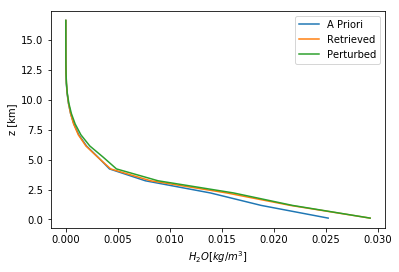

In [20]:
plt.plot(apriori_h2o, np.asarray(ws.z_field).ravel() * 1e-3, label="A Priori")
plt.plot(retrieved, np.asarray(ws.z_field).ravel() * 1e-3, label="Retrieved")
plt.plot(perturbed, np.asarray(ws.z_field).ravel() * 1e-3, label="Perturbed")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
#plt.xscale("log")
plt.legend()

In [21]:
ws.y.value

array([ 277.07307601,  270.72121556,  264.62464578,  257.43588112,
        251.26213303])

In [22]:
ws.z_field.value

array([[[   113.45732634]],

       [[  1174.69850948]],

       [[  2214.78098534]],

       [[  3230.62837179]],

       [[  4220.95953904]],

       [[  5190.62814644]],

       [[  6137.29444559]],

       [[  7067.33347732]],

       [[  7974.90050499]],

       [[  8848.74773843]],

       [[  9715.30139927]],

       [[ 10554.63973443]],

       [[ 11377.43937982]],

       [[ 12184.31355103]],

       [[ 12954.81499947]],

       [[ 13740.06643887]],

       [[ 14485.58976639]],

       [[ 15203.46285089]],

       [[ 15902.87697463]],

       [[ 16615.94036481]]])

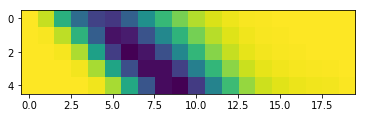

In [23]:
plt.imshow(ws.jacobian)